In [4]:
import os
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from tqdm import tqdm

from scipy.optimize import minimize
from sklearn.linear_model import LassoCV
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error, r2_score
from scipy.optimize import minimize
from utils.LassoFullyConnectedNeuralNetworkCV import LassoFullyConnectedNeuralNetworkCV
from utils.LassoFullyConnectedNeuralNetworkCV import LassoFullyConnectedNeuralNetwork

from utils.SampleWriter import AlphaPortDataset
from utils.GetDB import *

from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

import matplotlib.pyplot as plt
plt.style.use('seaborn')
import warnings
warnings.simplefilter('ignore')

import json

c:\Users\user\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [5]:
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [6]:
stockcode = pd.read_excel('stockcode.xlsx')
dict = stockcode.set_index('股票代號').to_dict()
TWSE_TF = pd.read_excel('TWSE_TF.xlsx')
TWSE_TF['股票代號'] = TWSE_TF['PID'].map(dict['股票名稱'])
TWSE_TF = TWSE_TF.dropna()
TWSE_TF['PID'] = TWSE_TF['PID'].astype(str)
benchmark_list = TWSE_TF['PID']
TWSE_TF = TWSE_TF.drop(columns='PID')
TWSE_TF = TWSE_TF.set_index('ActiveDate')
TWSE_TF = TWSE_TF.sort_index(ascending=True)
TWSE_TF = TWSE_TF['2023-01-03':'2023-08-09']
TWSE_TF = TWSE_TF.loc[TWSE_TF['股票代號']!='元大金']

TWSE_TF_gb = TWSE_TF.groupby(TWSE_TF.index)
weightlist = [TWSE_TF_gb.get_group(x) for x in TWSE_TF_gb.groups]
# transform weight
weightlist_new = []
for weightdf in weightlist:
    exclude_sum = weightdf['RefWeight'].sum()-weightdf[weightdf['股票代號']=='永豐金']['RefWeight']
    def new_weight(row):
        if row['股票代號'] == '永豐金':
            return 0.5
        else:
            return row['RefWeight']/exclude_sum*0.5
    weightdf.insert(0, 0, weightdf.apply(new_weight, axis = 1))
    weightdf = weightdf.drop(columns='RefWeight')
    weightdf = weightdf.set_index('股票代號', drop = True)
    weightlist_new.append(weightdf)

## functions

### 分群

In [16]:
def correlation_class(rr, target):
    rr_test = rr.dropna(axis = 1)
    yt = rr['元大金']
    rr_test = rr_test.drop('元大金', axis = 1)
    notyuanta = rr.columns
    corr_res = []
    for i in notyuanta:
        corr_res.append([i, yt.corr(rr[f'{i}'])])
    corr_res_df = pd.DataFrame(corr_res)
    corr_res_df.columns = ['股票名稱', '相關係數']
    corr_res_df = corr_res_df.sort_values('相關係數', ascending=False)[0:5]
    return list(corr_res_df['股票名稱'][0:5])

In [17]:
def pca_kmean_class(rr, target):
    rr = rr.dropna(axis = 1)
    rr_df_trans = rr.T
    scaler = MinMaxScaler()
    rr_df_scaled = scaler.fit_transform(rr_df_trans)
    pca = PCA(n_components = 3)
    trainn = pd.DataFrame(pca.fit_transform(rr_df_scaled))
    kmeans = KMeans(n_clusters = 4, random_state = 3425).fit(trainn.values)

    cluster_labels = pd.DataFrame(kmeans.labels_)
    Company = pd.DataFrame(rr_df_trans.index)
    df = pd.concat([Company, cluster_labels],axis = 1)
    df.columns = ['證券名稱', '群組別']
    clus_2885 = df[df['證券名稱']==f'{target}']['群組別'].values[0]
    return list(df[df['群組別'] == clus_2885]['證券名稱'].values)

In [18]:
def corr_kmean_class(rr, target):
    # rr_df -> 所有標的的歷史日報酬率
    vol_corr = (rr**2).rolling(20).sum().corr() # 相關係數矩陣
    # 分群數
    n_c = 4
    kmeans = KMeans(n_clusters = n_c, random_state = 123).fit(vol_corr.values)
    cluster_labels = pd.DataFrame(kmeans.labels_)
    Company = pd.DataFrame(vol_corr.index)
    df = pd.concat([Company, cluster_labels],axis = 1)
    df.columns = ['證券名稱', '群組別']
    clus_2885 = df[df['證券名稱']==f'{target}']['群組別'].values[0]
    return list(df[df['群組別'] == clus_2885]['證券名稱'].values)

### Train Weight

In [12]:
def prod_select(x_train, y_train, now_time, avg):
    def product_error(y_pred, y_true):
        y_true = np.array(y_true)/100+1
        y_pred = np.array(y_pred)/100+1
        return np.prod(y_pred) - np.prod(y_true)

    def objective_function(beta, X, Y):
        error = product_error(np.matmul(X,beta), Y)
        return error
    # provide a starting point at which to initialize the parameter search space
    beta_init = np.array([1/x_train.shape[1]]*x_train.shape[1])
    result = minimize(objective_function, beta_init, args=(x_train,y_train),
                    method='BFGS', options={'maxiter': 500})

    beta_hat = pd.DataFrame(result.x, index = x_train.columns)
    if avg:
        beta_hat = beta_hat/beta_hat.sum()
    return beta_hat

In [13]:
def lasso_select(x_train, y_train, now_time, avg):
    X = x_train.copy()
    Y = y_train.copy()
    X = X.dropna(axis = 1)
    # find best alpha
    lassocv = LassoCV(
        eps=0.001,
        cv=5,
        selection="cyclic",
        fit_intercept=False,
        verbose=False,
        positive=True,
        n_alphas=100,
        precompute=True,
        random_state=100
    )
    lassocv.fit(X, Y)
    best_alpha = lassocv.alpha_
    # plug in alpha
    lasso_best = Lasso(alpha=best_alpha, fit_intercept=False, positive=True, max_iter = 10000, random_state=5)
    lasso_best.fit(X, Y)
    lasso_result = pd.DataFrame(pd.Series(lasso_best.coef_, index = X.columns))
    if avg:
        lasso_result[0] = lasso_result[0]/lasso_result[0].sum()
    return lasso_result[lasso_result[0]!=0]

In [14]:
def lassoNN_select(x_train, y_train, now_time, avg, sample_weight=None):
    pid_names = list(x_train.columns)
    model = LassoFullyConnectedNeuralNetworkCV(
        eps=0.001,
        n_alphas=10,
        alphas=[],
        fit_intercept=False,
        epochs=100,
        learning_rate=1e-4,
        batch_size=16,
        batch_number=0,
        validation_split=0.1,
        random_state=0,
        patience=50,
        positive=True,
        cv=5,
        selection="cyclic",
        maximum_number_of_iteration=100
    )
    model.fit(
        np.array(x_train), # 862, 41
        np.array(y_train),  # 862,
    )
    weights = model.coef_
    if avg:
        weights /= np.sum(weights)
    lassoNN_result = pd.DataFrame(
        {
            0: weights
        }
    )
    lassoNN_result.index = pid_names
    lassoNN_result = lassoNN_result[lassoNN_result[0] != 0]
    return lassoNN_result

In [15]:
def twse_tff(x_train, y_train, now_time, avg, weight_l = weightlist_new):
    return weight_l[now_time]

### 回測

In [23]:
def cal_holding(new_best_w, principal, price_df_now):
    holdings = (new_best_w[0]*principal/price_df_now/1000).apply(np.around)
    holding_df = pd.concat([new_best_w[0], holdings, price_df_now], axis = 1)
    holding_df.columns = ['權重', '張數', '當期價格']
    holding_df = holding_df.sort_values('權重', ascending=False)
    gap = (holding_df['張數']*1000*holding_df['當期價格']).sum() - principal
    #print(gap, holding_df)
    a = 0
    while gap < 0 and a < len(holding_df['當期價格']):
        if gap + holding_df.iat[a, 2]*1000 > 0:
            a += 1
            continue
        holding_df.iat[a, 1] = holding_df.iat[a, 1] + 1
        gap = gap + holding_df.iat[a, 2]*1000
        a += 1
    
    b = len(holding_df['當期價格'])-1
    while gap > 0 and b >= 0:
        if pd.isnull(holding_df.iat[b, 1]):
            b -= 1
            continue
        if gap - holding_df.iat[b, 2]*1000 < 0:
            b -= 1
            continue
        holding_df.iat[b, 1] = holding_df.iat[b, 1] - 1
        gap = gap - holding_df.iat[b, 2]*1000
        b -= 1
    gap = (holding_df['張數']*1000*holding_df['當期價格']).sum() - principal
    holding_df = holding_df.fillna(0)
    #print(gap, holding_df)
    return holding_df, gap

In [24]:
def switch_method(last, now):
    if len(last) == 0:
        last = pd.DataFrame([[np.nan]*3])
    if len(now) == 0:
        now = pd.DataFrame([[np.nan]*3])

    switch = pd.concat([last, now], axis = 1)
    switch.columns = ['last w', 'last num', 'last price', 'now w', 'now num', 'now price']
    switch = switch.fillna(0)
    switch.insert(6, '差異', switch['now num'] - switch['last num'])
    def cal_cost(row):
        if row['差異'] > 0:
            return -np.rint(abs(row['now price']*row['差異']*1000*0.000052))
        elif row['差異'] < 0:
            return -np.rint(abs(row['now price']*row['差異']*1000*(0.000052+0.003)))
        else:
            return 0
    switch['cost'] = switch.apply(cal_cost, axis=1)
    def PorL(row):
        return row['last num']*(row['now price'] - row['last price'])*1000
    switch['P&L'] = switch.apply(PorL, axis=1)
    return switch['cost'].sum(), switch['P&L'].sum(), switch

In [25]:
def CapitalTracker(now_holding_list, switch_process, interval):
    cum_capital = []
    total_capital = (now_holding_list[0]['張數'] * now_holding_list[0]['當期價格'] * 1000).sum() \
                    + (now_holding_list[0]['張數'] * now_holding_list[0]['當期價格'] * 1000 * 0.000052).sum()
    cum_capital.extend([total_capital for i in range(interval)])
    for idx, switch in enumerate(switch_process):
        for index, row in switch.iterrows():
            total_capital += row['差異'] * row['now price'] * 1000 # 買入則成本增加、賣出成本下降
            total_capital += np.abs(row['差異'] * row['now price'] * 1000 * 0.000052)
            if row['差異'] < 0: # 賣出的稅
                total_capital += np.abs(row['差異'] * row['now price'] * 1000 * 0.003)
        cum_capital.extend([total_capital for i in range(interval)])
    return cum_capital

In [22]:
def find_mdd(pl_list): # 最大連續虧損
    maximum = 0
    mdd = 0
    for p in pl_list:
        if p > maximum:
            maximum = p
        dd = p - maximum
        if dd < mdd:
            mdd = dd
    return mdd

def find_maxgain(pl_list): # 最大連續獲利
    minimum = 0
    maxgain = 0
    for p in pl_list:
        if p < minimum:
            minimum = p
        gain = p - minimum
        if gain > maxgain:
            maxgain = gain
    return maxgain

def pl_MSE(pl_list):
    n = 0
    sse = 0
    for e in pl_list:
        n += 1
        sse += e*e
    return sse/n

In [21]:
def MetricReport(
    pl, mg, mdd, pl_process_2885, pl_process_copy, 
    cum_capital_2885, cum_capital_copy, date_list, name, output_dir=None
):
    if os.path.exists(output_dir) == False:
        os.makedirs(output_dir)
    fig, ax = plt.subplots(2,1,figsize=(10,12), sharex=True)
    # plot pl process
    pl = "{:,.0f}".format(int(pl))
    mg = "{:,.0f}".format(int(mg))
    mdd = "{:,.0f}".format(int(mdd))
    temp1 = pd.DataFrame(
        {
            "Target": pl_process_2885,
            "Copy": pl_process_copy
        }
    )
    temp1.index = date_list
    temp1.plot(ax=ax[0])
    ax[0].set_title(
        f"Model: Lasso, PL: {pl}, MaxGain: {mg}, MaxDrawDown: {mdd}",
        fontsize=14 
    )
    # plot pl diff return
    temp2 = pd.DataFrame(
        {
            "PL Diff(%)": np.array(pl_process_copy) / np.array(cum_capital_copy) - np.array(pl_process_2885) / np.array(cum_capital_copy)
        }
    )
    temp2.index= date_list
    temp2.plot(ax=ax[1])
    plt.hlines(y=0, xmin=0, xmax=len(pl_process_copy), linestyles='--', color='black')
    plt.savefig(f"{output_dir}/{name}_{date_list[0].replace('/','')}_{date_list[-1].replace('/','')}.png", bbox='tight')

In [20]:
def performance(target, rr_df, day1, interval, price_df, select_class, select_method, avg, cluster = True, sample_weight=None):
    new_best_w = pd.DataFrame()
    now_holding = pd.Series(0.0)
    price_df_now = pd.Series(0.0)
    rr_test_df = pd.DataFrame()
    total_switch_cost = 0
    gap_list = []
    switch_process = []
    last_holding_list, now_holding_list = [], []
    switchpl_list = []
    mkt_value_2885, mkt_value_copy = [], []
    weight_list = []
    multi_l = []
    
    steps = (len(rr_df)-day1)//interval
    for t in range(steps+1): # 當固定時間區間，不斷迭代訓練資料
        rr_df_train = rr_df[interval*t:day1+interval*t].copy()
        #print(f"Training period: {rr_df_train.index[0]} ~ {rr_df_train.index[-1]}")
        # 1/2 ~ 6/22 Choose stock
        if cluster:
            kmean_l = select_class(rr_df_train, target)
            rr_df_train = rr_df_train.loc[:, kmean_l]
        # 訓練weight
        x_train = rr_df_train.drop([f'{target}'], axis = 1)
        y_train = rr_df_train[f'{target}']
        last_best_w = new_best_w
        new_best_w = select_method(x_train, y_train, interval*t, avg)
        weight_list.append(new_best_w)
        multi = new_best_w.sum()[0]
        new_best_w = new_best_w / new_best_w.sum()
        # 1/2 ~ 6/22 訓練出來的weight在6/23建倉，principal 應該要是6/23才對
        # now_holding 表示 6/23 建倉後持有的數量，price_df_now 也應該是 6/23的價格
        if t < steps:
            price_df_test = price_df.iloc[day1+interval*t:day1+interval*(t+1)].copy()
        else:
            price_df_test = price_df.iloc[day1+interval*t:].copy()
        #print(f"Testing period: {price_df_test.index[0]} ~ {price_df_test.index[-1]}")
        y_price_test = price_df_test[f'{target}']
        if t == 0:
            x_price_test = price_df_test[list(new_best_w.index)]
        else:
            x_price_test = price_df_test[list(last_best_w.index.union(new_best_w.index))]
        # 調倉後的持有數量
        try:
            price_df_now = x_price_test.iloc[0]
        except:
            break
        principal = y_price_test.iloc[0]*271000*multi
        last_holding = now_holding
        now_holding, gap = cal_holding(new_best_w, principal, price_df_now) # 張數
        gap_list.append([t, gap])
        last_holding_list.append(last_holding)
        now_holding_list.append(now_holding)
        # Profit and Loss
        x_price_test = x_price_test[now_holding.index]
        mkt_value_2885.append(y_price_test*271000)
        mkt_value_copy.append(x_price_test.dot(now_holding['張數'])*1000)
        # rate of return
        if t < steps:
            rr_test = rr_df[day1+interval*t:day1+interval*(t+1)].copy()
        else:
            rr_test = rr_df[day1+interval*t:].copy()
        x_rr_test = rr_test.drop([f'{target}'], axis = 1)
        y_rr_test = rr_test[f'{target}']
        selected = list(new_best_w.index)
        x_rr_test = x_rr_test[selected]
        x_rr_test = x_rr_test.dot(new_best_w)
        rr_test_df1 = pd.concat([y_rr_test, x_rr_test], axis = 1)
        rr_test_df = pd.concat([rr_test_df, rr_test_df1], axis = 0)
        
        if t == 0:
            switch_cost = 0
        else:
            switch_cost, switchPL, switch  = switch_method(last_holding, now_holding)
            switch.insert(0, 'test d1', price_df_test.index[0])
            switch_process.append(switch)
            switchpl_list.append(switch_cost + switchPL)

    rr_test_df.columns = ['rr_yt', 'rr_p']
    return weight_list, switch_process, mkt_value_2885, mkt_value_copy, last_holding_list, now_holding_list # 當固定時間區間下，執行的細節

## Main

### Data preparation

In [7]:
dataset = AlphaPortDataset(
    usecols=['股票代號','日期','收盤價', '股票名稱', '總市值(億)'],
    start='20200101',
    end='20230808'
)

Loading stock data from Cmoney ..........
Combine each pid by multi-index ..........


In [32]:
# Choose target
target = '元大金'

df_fingroup = pd.read_excel('./FinanceGroup.xlsx')
df_fingroup['Pid'] = df_fingroup['Pid'].astype(str)
select_list = df_fingroup['Pid'].to_list()
# select_list = list(set(list(benchmark_list.unique())) | set(select_list))

In [33]:
# rr & price
def rrandprice(dataset, select_list):
    df_close = dataset.df['Close'][select_list]
    df_pct   = dataset.df['Close'].pct_change()[select_list]
    dates, name, close, pct = [], [], [], []
    for i in range(len(df_close)):
        price_ = df_close.iloc[i].values
        date_  = df_close.index[i][:4] + '/' + df_close.index[i][4:6] + '/' + df_close.index[i][6:]
        dates  += [date_ for i in range(len(price_))]
        name   += list(dataset.df['股票名稱'].iloc[0, :][select_list].values)
        close  += list(price_)
        pct    += list(df_pct.iloc[i].values)
    data = pd.DataFrame(
        {
            "股票名稱": name,
            "收盤價": close,
            "漲幅(%)": pct
        }
    )
    data.index = dates
    data.index.rename('日期', inplace=True)
    data = data.dropna()

    rr = data.drop(['收盤價'], axis=1)
    rr['漲幅(%)'] = rr['漲幅(%)']*100
    price = data.drop(['漲幅(%)'], axis=1)

    l1 = list(rr['股票名稱'].unique())
    rr_df = pd.DataFrame()
    for i in l1:
        m = rr[rr['股票名稱']==i]['漲幅(%)']
        rr_df.insert(0, f'{i}', m)

    l2 = list(price['股票名稱'].unique())
    price_df = pd.DataFrame()
    for i in l2:
        m = price[price['股票名稱']==i]['收盤價']
        price_df.insert(0, f'{i}', m)
    return rr_df, price_df
rr_df, price_df = rrandprice(dataset, select_list)
rr_df = rr_df.dropna(axis = 1)
price_df = price_df.dropna(axis = 1)

In [39]:
select_list2 = list(benchmark_list.unique())

In [40]:
rr_df2, price_df2 = rrandprice(dataset, select_list2)
rr_df2 = rr_df2.dropna(axis = 1)
price_df2 = price_df2.dropna(axis = 1)

### Execution

##### all model

In [ ]:
filter_list = input().split(',')
# example: corr,lasso,Avgon

# 'corr', 'corr_kmean', 'pca_kmean'
# 'lasso', 'lassoNN', 'prod', 'given'
# 'Avgon', 'Avgoff'

In [72]:
def filtering(filter_list):
    if filter_list[0] == 'corr':
        classify = correlation_class
    if filter_list[0] == 'corr_kmean':
        classify = corr_kmean_class
    if filter_list[0] == 'pca_kmean':
        classify = pca_kmean_class

    if filter_list[1] == 'lasso':
        selection = lasso_select
    if filter_list[1] == 'lassoNN':
        selection = lassoNN_select
    if filter_list[1] == 'prod':
        selection = prod_select
    if filter_list[1] == 'twse_tff':
        selection = twse_tff

    if filter_list[2] == 'Avgon':
        avg = True
    if filter_list[2] == 'Avgoff':
        avg = False
    return classify, selection, avg

In [75]:
class_method = ['corr', 'corr_kmean', 'pca_kmean']
select_method = ['lasso', 'prod', 'twse_tff']#, 'lassoNN'] # 'lasso', 'prod', 'given', ,'lassoNN'
weightsum = ['Avgon', 'Avgoff']

all_conseq = []
for i in class_method:
    for j in select_method:
        for s in weightsum:
            all_conseq.append([i,j,s])

In [ ]:
all_res = []
for filter_list in tqdm(all_conseq):
    classfication, selection, avg = filtering(filter_list)
    clustering = False

    output_dir = f'./result2885_3/2885_{filter_list[0]}_{filter_list[1]}_{filter_list[2]}/'
    backtest_start = '2023/01/01'

    all_fit_days = [60,100,200,400] # 要用多少天數 fit Lasso
    res = []
    holding_record = []

    for day1 in tqdm(all_fit_days):
        start = day1 + len(rr_df.loc[backtest_start:])
        level = len(rr_df.loc[backtest_start:])//10
        for i in range(level):
            interval = 5*(i+1)
            weight_list, switch_process, mkt_value_2885, mkt_value_copy, last_holding_hist, now_holding_list \
                = performance(target, rr_df.iloc[-start:], day1, interval, price_df.iloc[-start:], classfication, selection, avg, clustering)
            # ---------- add transaction cost into DAILY pl list ----------
            # 2885
            mv2885_df = pd.concat(mkt_value_2885)
            cum_capital_2885 = mv2885_df[0] + mv2885_df[0]*0.000052
            cum_capital_2885 = pd.Series([cum_capital_2885 for i in range(len(mv2885_df))], mv2885_df.index)
            pl_process_2885 = mv2885_df - cum_capital_2885  # PL = 元大市值 - 元大本金
            # copy
            mvcopy_df = pd.concat(mkt_value_copy)
            cum_capital_copy = CapitalTracker(now_holding_list, switch_process, interval)
            for _ in range(int(len(cum_capital_copy) - len(mvcopy_df))):
                cum_capital_copy.pop() # 移除不滿 interval 多餘的天數
            pl_process_copy = mvcopy_df - cum_capital_copy
            # record hoding history
            df_holding = []
            for idx, holding in enumerate(now_holding_list):
                holding['日期'] = mkt_value_copy[idx].index[0]
                df_holding.append(holding)
            df_holding = pd.concat(df_holding, axis=0)
            df_holding['Mode'] = f"{day1}_{interval}"
            holding_record.append(df_holding)
            # ----------------------- metric -----------------------
            date_list = []
            for m in mkt_value_copy:
                date_list += m.index.to_list()

            totalPL = pl_process_copy[-1]/cum_capital_copy[-1] - pl_process_2885[-1]/cum_capital_2885[-1]
            mse = mean_squared_error(pl_process_copy, pl_process_2885)
            error = pl_process_copy - pl_process_2885
            error_pct = pl_process_copy/cum_capital_copy - pl_process_2885/cum_capital_2885
            maxdrawdown = find_mdd(error_pct)
            maxgain = find_maxgain(error_pct)
            max_ = np.max(error_pct)
            min_ = np.min(error_pct)
            tracking_error = np.sum(np.abs(error))
            res.append([filter_list, day1, interval, mse, maxdrawdown, maxgain, max_, min_, tracking_error, totalPL])
            MetricReport(totalPL,maxgain,maxdrawdown,pl_process_2885,pl_process_copy,cum_capital_2885, cum_capital_copy,date_list,f"{day1}_{interval}", output_dir)

    res_df = pd.DataFrame(res, columns=['Model','train day', 'Interval', 'MSE', 'MaxDrawdown', 'Maxgain', 'MAX(%)', 'MIN(%)', 'Tracking Error', 'Total PL'])
    res_df['Penalty1'] = res_df['MAX(%)'] + res_df['MIN(%)'].abs()
    res_df['Penalty2'] = res_df['Maxgain'] + res_df['MaxDrawdown'].abs()
    
    res_df = res_df.sort_values('Tracking Error',ascending=True)
    all_res.append(res_df.iloc[0])
    res_df.to_excel(f"{output_dir}/Metric_{filter_list[0]}_{filter_list[1]}_{filter_list[2]}.xlsx", index=False)
    df_holding_record = pd.concat(holding_record, axis=0)
    df_holding_record.to_excel(f"{output_dir}/HoldingRecord.xlsx")


In [77]:
all_res_df = pd.DataFrame(all_res).sort_values('Tracking Error')
all_res_df.to_excel('all_res_0830.xlsx')

##### certain model

In [41]:
def certain_day(rr_df, price_df, classfication, selection, avg, day1, interval, clustering):
    backtest_start = '2023/01/01'
    res = []
    holding_record = []

    start = day1 + len(rr_df.loc[backtest_start:])
    level = len(rr_df.loc[backtest_start:])//10

    weight_list, switch_process, mkt_value_2885, mkt_value_copy, last_holding_hist, now_holding_list \
        = performance(target, rr_df.iloc[-start:], day1, interval, price_df.iloc[-start:], classfication, selection, avg, clustering)
    # ---------- add transaction cost into DAILY pl list ----------
    # 2885
    mv2885_df = pd.concat(mkt_value_2885)
    cum_capital_2885 = mv2885_df[0] + mv2885_df[0]*0.000052
    cum_capital_2885 = pd.Series([cum_capital_2885 for i in range(len(mv2885_df))], mv2885_df.index)
    pl_process_2885 = mv2885_df - cum_capital_2885  # PL = 元大市值 - 元大本金
    # copy
    mvcopy_df = pd.concat(mkt_value_copy)
    cum_capital_copy = CapitalTracker(now_holding_list, switch_process, interval)
    for _ in range(int(len(cum_capital_copy) - len(mvcopy_df))):
        cum_capital_copy.pop() # 移除不滿 interval 多餘的天數
    pl_process_copy = mvcopy_df - cum_capital_copy
    # record hoding history
    df_holding = []
    for idx, holding in enumerate(now_holding_list):
        holding['日期'] = mkt_value_copy[idx].index[0]
        df_holding.append(holding)
    df_holding = pd.concat(df_holding, axis=0)
    df_holding['Mode'] = f"{day1}_{interval}"
    holding_record.append(df_holding)
    # ----------------------- metric -----------------------
    date_list = []
    for m in mkt_value_copy:
        date_list += m.index.to_list()

    totalPL = pl_process_copy[-1]/cum_capital_copy[-1] - pl_process_2885[-1]/cum_capital_2885[-1]
    mse = mean_squared_error(pl_process_copy, pl_process_2885)
    error = pl_process_copy - pl_process_2885
    error_pct = pl_process_copy/cum_capital_copy - pl_process_2885/cum_capital_2885
    maxdrawdown = find_mdd(error_pct)
    maxgain = find_maxgain(error_pct)
    max_ = np.max(error_pct)
    min_ = np.min(error_pct)
    tracking_error = np.sum(np.abs(error))
    res_list = [day1, interval, mse, maxdrawdown, maxgain, max_, min_, tracking_error, totalPL]
    return totalPL, maxgain, maxdrawdown, pl_process_2885, pl_process_copy, cum_capital_2885, cum_capital_copy,date_list, f"{day1}_{interval}", max_, min_, res_list

In [42]:
totalPL, maxgain, maxdrawdown, pl_process_2885, pl_process_copy, cum_capital_2885, cum_capital_copy, date_list, dayandinterval, max_, min_, res_list \
     = certain_day(rr_df, price_df, corr_kmean_class, lasso_select, False, 200, 65, False)
totalPL2, maxgain2, maxdrawdown2, pl_process_28852, pl_process_copy2, cum_capital_28852, cum_capital_copy2, date_list2, dayandinterval2, max_2, min_2, res_list2 \
      = certain_day(rr_df2, price_df2, corr_kmean_class, twse_tff, True, 60, 45, False)

In [38]:
res_list

[200,
 65,
 3341313845.194271,
 -0.07737436219163449,
 0.044106512602479456,
 0.028456635051947725,
 -0.048917727139686756,
 6582420.64084,
 -0.0471108132677511]

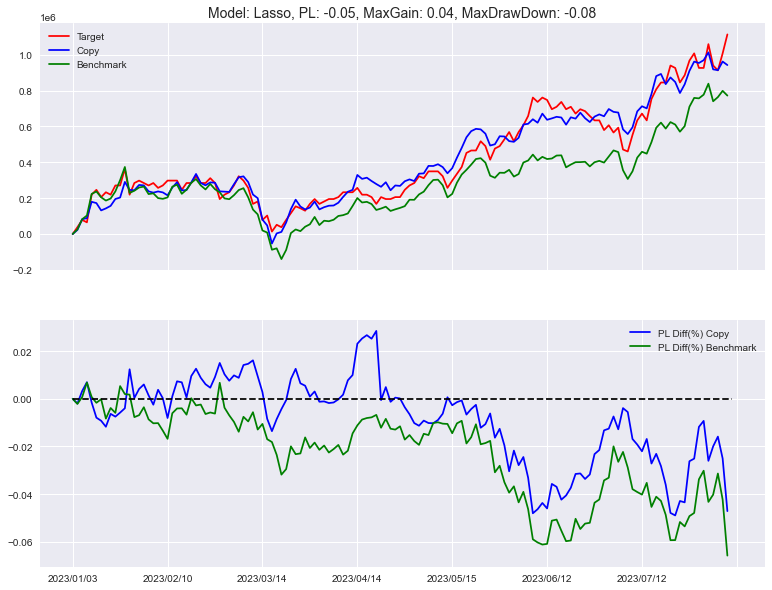

In [43]:
fig, ax = plt.subplots(2,1,figsize=(13,10), sharex=True)
pl = "{:,.2f}".format(float(totalPL))
mg = "{:,.2f}".format(float(maxgain))
mdd = "{:,.2f}".format(float(maxdrawdown))

temp1 = pd.DataFrame(
    {
        "Target": pl_process_2885,
        "Copy": pl_process_copy,
        "Benchmark": pl_process_copy2,
    }
)
temp1.index = date_list
temp1.plot(ax=ax[0], style={"Target":'r', "Copy":'b', 'Benchmark':'g'})
ax[0].set_title(
    f"Model: Lasso, PL: {pl}, MaxGain: {mg}, MaxDrawDown: {mdd}",
    fontsize=14 
)
# plot pl diff return
temp2 = pd.DataFrame(
    {
        "PL Diff(%) Copy": np.array(pl_process_copy) / np.array(cum_capital_copy) - np.array(pl_process_2885) / np.array(cum_capital_2885),
        "PL Diff(%) Benchmark": np.array(pl_process_copy2) / np.array(cum_capital_copy2) - np.array(pl_process_28852) / np.array(cum_capital_28852),
    }
)
temp2.index= date_list
temp2.plot(ax=ax[1], style={"PL Diff(%) Copy":'b', "PL Diff(%) Benchmark":'g'})
plt.hlines(y=0, xmin=0, xmax=len(pl_process_copy), linestyles='--', color='black')
#plt.savefig(f"{output_dir}/{name}_{date_list[0].replace('/','')}_{date_list[-1].replace('/','')}.png", bbox='tight')
plt.show()

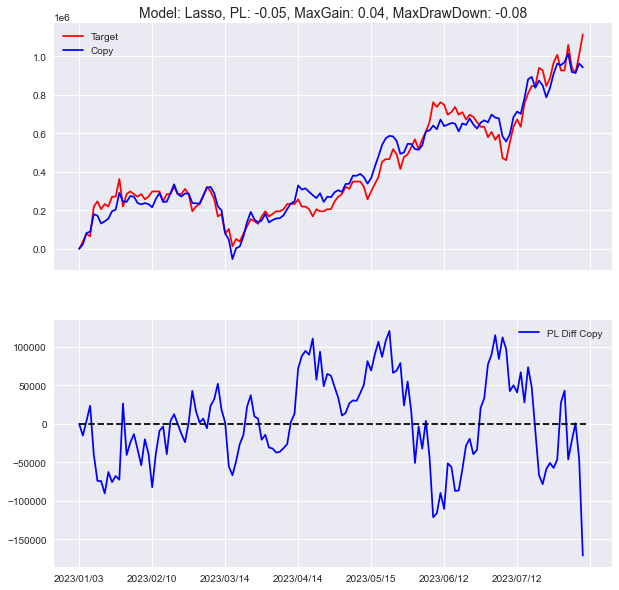

In [47]:
fig, ax = plt.subplots(2,1,figsize=(10,10), sharex=True)
pl = "{:,.2f}".format(float(totalPL))
mg = "{:,.2f}".format(float(maxgain))
mdd = "{:,.2f}".format(float(maxdrawdown))

temp1 = pd.DataFrame(
    {
        "Target": pl_process_2885,
        "Copy": pl_process_copy,
    }
)
temp1.index = date_list
temp1.plot(ax=ax[0], style={"Target":'r', "Copy":'b'})
ax[0].set_title(
    f"Model: Lasso, PL: {pl}, MaxGain: {mg}, MaxDrawDown: {mdd}",
    fontsize=14 
)
# plot pl diff return
temp2 = pd.DataFrame(
    {
        "PL Diff Copy": np.array(pl_process_copy) - np.array(pl_process_2885),
    }
)
temp2.index= date_list
temp2.plot(ax=ax[1], style={"PL Diff Copy":'b'})
plt.hlines(y=0, xmin=0, xmax=len(pl_process_copy), linestyles='--', color='black')
#plt.savefig(f"{output_dir}/{name}_{date_list[0].replace('/','')}_{date_list[-1].replace('/','')}.png", bbox='tight')
plt.show()

##### one day

In [ ]:
lasso_res = []
holding_record = []
avg = False # 不讓 weight sum = 1 則為 False
output_dir = './result/6282_LassoPos_AvgOff_all_kmean20/'
backtest_start = '2023/02/23'

day1 = 200
start = day1 + len(rr_df.loc[backtest_start:])
level = len(rr_df.loc[backtest_start:])//10
interval = 40
weight_list, switch_process, mkt_value_2885, mkt_value_copy, total_cost_list, last_holding_hist, now_holding_list \
    = performance(rr_df.iloc[-start:], day1, interval, price_df.iloc[-start:], lasso_select, avg)
# ---------- add transaction cost into DAILY pl list ----------
# 2885
mv2885_df = pd.concat(mkt_value_2885)
pl_process_2885 = mv2885_df-(mv2885_df[0]-mv2885_df[0]*0.000052)  # PL = 元大市值 - 元大本金
# copy
mvcopy_df = pd.concat(mkt_value_copy)
cum_capital_copy = CapitalTracker(now_holding_list, switch_process, interval)
for _ in range(int(len(cum_capital_copy) - len(mvcopy_df))):
    cum_capital_copy.pop() # 移除不滿 interval 多餘的天數
pl_process_copy = mvcopy_df - cum_capital_copy
# record hoding history
df_holding = []
for idx, holding in enumerate(now_holding_list):
    holding['日期'] = mkt_value_copy[idx].index[0]
    df_holding.append(holding)
df_holding = pd.concat(df_holding, axis=0)
df_holding['Mode'] = f"{day1}_{interval}"
holding_record.append(df_holding)
# ----------------------- metric -----------------------
date_list = []
for m in mkt_value_copy:
    date_list += m.index.to_list()

totalPL = pl_process_copy[-1] - pl_process_2885[-1]
mse = mean_squared_error(pl_process_copy, pl_process_2885)
error = pl_process_copy - pl_process_2885
maxdrawdown = find_mdd(error)
maxgain = find_maxgain(error)
max_ = np.max(error)
min_ = np.min(error)
tracking_error = np.sum(np.abs(error))
lasso_res.append([day1, interval, mse, maxdrawdown, maxgain, max_, min_, tracking_error, totalPL])
lasso_res_df = pd.DataFrame(lasso_res, columns=['Model','Interval', 'MSE', 'MaxDrawdown', 'Maxgain', 'MAX', 'MIN', 'Tracking Error', 'Total PL'])
lasso_res_df
# MetricReport(output_dir,totalPL,maxgain,maxdrawdown,pl_process_2885,pl_process_copy,date_list,f"{day1}_{interval}")

## analysis

In [ ]:
pd.DataFrame(gap_list).describe()

In [ ]:
sns.displot(pl_df)
pd.DataFrame(pl_df).describe()

In [ ]:
figure(figsize=(15, 6), dpi=100)
plt.axhline(y = 0, color='r')
plt.plot(pl_df[:200])

In [ ]:
figure(figsize=(15, 6), dpi=100)
plt.plot(rr_test_df['rr_yt'])
plt.plot(rr_test_df['rr_p'])
plt.show()

In [ ]:
def pca_kmean_choose(rr):
    rr = rr.dropna()
    rr_df_trans = rr.T
    scaler = MinMaxScaler()
    rr_df_scaled = scaler.fit_transform(rr_df_trans)
    pca = PCA(n_components = 3)
    trainn = pd.DataFrame(pca.fit_transform(rr_df_scaled))
    distortions = []
    scores = []
    for k in range(2, 30):
        kmeans = KMeans(n_clusters = k).fit(trainn.values)
        distortions.append(kmeans.inertia_)
        scores.append(silhouette_score(trainn.values, kmeans.predict(rr_df_trans)))
    
    selected_K = scores.index(max(scores)) + 2
    kmeans = KMeans(n_clusters = selected_K).fit(rr_df_trans)

    # 繪製誤差平方和圖 (手肘法)
    figure(figsize=(15, 6), dpi=100)
    plt.title('SSE (elbow method)')
    plt.plot(range(2, 30), distortions)
    plt.plot(selected_K, distortions[selected_K - 2], 'go') # 最佳解

    cluster_labels = pd.DataFrame(kmeans.labels_)
    Company = pd.DataFrame(rr_df_trans.index)
    df = pd.concat([Company, cluster_labels],axis = 1)
    df.columns = ['證券名稱', '群組別']
    clus_2885 = df[df['證券名稱']==f'{target}']['群組別'].values[0]
    return list(df[df['群組別'] == clus_2885]['證券名稱'].values)

In [ ]:
!jupyter nbconvert --to python trading0811.ipynb